In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
# so that you need to use print()
from __future__ import print_function
titles = open('data/title_list.txt').read().split('\n')

In [3]:
len(titles)

101

In [4]:
titles[:10]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic']

In [5]:
titles = titles[:100]

In [6]:
genres = open('data/genres_list.txt').read().split('\n')
genres = genres[:100]

In [7]:
genres[0]

"[u' Crime', u' Drama']"

In [8]:
synopses_wiki = open('data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')

In [9]:
len(synopses_wiki)

101

In [10]:
synopses_wiki = synopses_wiki[:100]

In [11]:
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

In [12]:
synopses_imdb = open('data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_imdb.append(text)
synopses_imdb = synopses_clean_imdb

In [13]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [14]:
print(str(len(titles)) + ' titles')
print(str(len(genres)) + ' genres')
print(str(len(synopses)) + ' synopses')

100 titles
100 genres
100 synopses


In [15]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
# the movies in the list are already ranked from 1 to 100
ranks = []
for i in range(1, len(titles)+1):
    ranks.append(i)

In [16]:
# load nltk's English stopwords as variable called 'stopwords'
# use nltk.download() to install the corpus first
# Stop Words are words which do not contain important significance to be used in Search Queries
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [17]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
# Punkt Sentence Tokenizer, sent means sentence 
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [18]:

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized

In [19]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [20]:
print(len(totalvocab_stemmed))
print(len(totalvocab_tokenized))

312302
312302


In [21]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame.head())

there are 312302 items in vocab_frame
     words
plot  plot
edit  edit
edit  edit
edit  edit
on      on


Generate TF-IDF matrix (see http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams

In [23]:
# Note that the result of this block takes a while to show
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

# (100, 563) means the matrix has 100 rows and 563 columns
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
len(terms)

/home/harsh/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 11.1 s, sys: 94.3 ms, total: 11.2 s
Wall time: 11.4 s
(100, 563)


563

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima - how to decide that the algorithm converged???

In [39]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 231 ms


In [42]:
import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
# clusters show which cluster (0-4) each of the 100 synoposes belongs to
print(len(clusters))
print(clusters)

100
[4, 4, 3, 4, 1, 2, 3, 4, 2, 2, 3, 4, 4, 1, 4, 4, 3, 1, 1, 3, 2, 4, 4, 4, 3, 1, 0, 4, 4, 3, 4, 3, 1, 3, 3, 1, 3, 3, 3, 4, 4, 0, 4, 0, 3, 4, 2, 3, 3, 4, 3, 4, 3, 3, 1, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 0, 4, 0, 4, 2, 4, 4, 1, 4, 4, 0, 4, 3, 2, 3, 3, 2, 1, 1, 2, 4, 4, 3, 3, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 0]


Here, I create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre [rank and genre were scraped from IMDB].
I convert this dictionary to a Pandas DataFrame for easy access. I'm a huge fan of Pandas and recommend taking a look at some of its awesome functionality which I'll use below, but not describe in a ton of detail.

In [43]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

print(frame) # here the ranking is still 0 to 99

frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)


    rank                     title  cluster  \
4      1             The Godfather        4   
4      2  The Shawshank Redemption        4   
3      3          Schindler's List        3   
4      4               Raging Bull        4   
1      5                Casablanca        1   
..   ...                       ...      ...   
4     96     Rebel Without a Cause        4   
4     97               Rear Window        4   
4     98             The Third Man        4   
4     99        North by Northwest        4   
0    100       Yankee Doodle Dandy        0   

                                         genre  
4                       [u' Crime', u' Drama']  
4                       [u' Crime', u' Drama']  
3      [u' Biography', u' Drama', u' History']  
4        [u' Biography', u' Drama', u' Sport']  
1            [u' Drama', u' Romance', u' War']  
..                                         ...  
4                                  [u' Drama']  
4                  [u' Mystery', u' Thrille

4    42
3    30
1    11
2    10
0     7
Name: cluster, dtype: int64

In [44]:
grouped = frame['rank'].groupby(frame['cluster']) # groupby cluster for aggregation purposes

grouped.mean() # average rank (1 to 100) per cluster

cluster
0    60.428571
1    40.545455
2    50.300000
3    47.733333
4    53.476190
Name: rank, dtype: float64

Note that clusters 4 and 0 have the lowest rank, which indicates that they, on average, contain films that were ranked as "better" on the top 100 list.
Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [49]:
from __future__ import print_function

print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

print(order_centroids)
print("__________________________________________________________________")
print(frame)


Top terms per cluster:
[[227 317 366 ... 492 530 443]
 [313 215 463 ... 525 530 195]
 [255 333 205 ... 554  89 281]
 [ 41 532 286 ... 539 371  27]
 [207  91 376 ... 554 264  60]]
__________________________________________________________________
    rank                     title  cluster  \
4      1             The Godfather        4   
4      2  The Shawshank Redemption        4   
3      3          Schindler's List        3   
4      4               Raging Bull        4   
1      5                Casablanca        1   
..   ...                       ...      ...   
4     96     Rebel Without a Cause        4   
4     97               Rear Window        4   
4     98             The Third Man        4   
4     99        North by Northwest        4   
0    100       Yankee Doodle Dandy        0   

                                         genre  
4                       [u' Crime', u' Drama']  
4                       [u' Crime', u' Drama']  
3      [u' Biography', u' Drama', u' Histo

Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). cosine similarity 1 means the same document, 0 means totally different ones. dist is defined as 1 - the cosine similarity of each document.  Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [51]:

similarity_distance = 1 - cosine_similarity(tfidf_matrix)
print(similarity_distance)
print(similarity_distance.shape)

[[ 0.00000000e+00  8.00539634e-01  7.62813109e-01 ...  6.41312416e-01
   6.70578229e-01  8.23926244e-01]
 [ 8.00539634e-01 -2.22044605e-16  7.33477850e-01 ...  7.33117814e-01
   7.71609239e-01  8.92974798e-01]
 [ 7.62813109e-01  7.33477850e-01  0.00000000e+00 ...  7.23806699e-01
   7.49489708e-01  8.58673233e-01]
 ...
 [ 6.41312416e-01  7.33117814e-01  7.23806699e-01 ...  0.00000000e+00
   4.50879024e-01  9.17464687e-01]
 [ 6.70578229e-01  7.71609239e-01  7.49489708e-01 ...  4.50879024e-01
   2.22044605e-16  8.68599864e-01]
 [ 8.23926244e-01  8.92974798e-01  8.58673233e-01 ...  9.17464687e-01
   8.68599864e-01 -2.22044605e-16]]
(100, 100)


Multidimensional scaling
Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [52]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)

print(pos.shape)
print(pos)

xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))
xs

CPU times: user 1.23 s, sys: 697 ms, total: 1.93 s
Wall time: 737 ms
(100, 2)
[[ 0.18427284 -0.01171561]
 [ 0.44206412 -0.27869805]
 [-0.03159215 -0.45663791]
 [-0.13227196  0.57453848]
 [-0.25873684 -0.26527517]
 [ 0.05822957  0.25692953]
 [ 0.05839902 -0.04612822]
 [ 0.01170734  0.46244858]
 [-0.43458221 -0.29655933]
 [ 0.60374328 -0.34569913]
 [-0.25090779 -0.57483017]
 [ 0.0716498   0.13140843]
 [-0.22775176  0.06867225]
 [-0.43012185  0.28528616]
 [-0.35275605  0.12706104]
 [-0.05321665  0.12337032]
 [ 0.35480636  0.00823039]
 [ 0.5523204   0.49066955]
 [-0.48429635  0.17299124]
 [ 0.19843842 -0.38929168]
 [-0.0217225  -0.04277899]
 [ 0.35008658 -0.33952163]
 [ 0.51778119 -0.25366187]
 [-0.55230241 -0.22470452]
 [-0.08222117 -0.57833712]
 [-0.34166784  0.63444443]
 [ 0.41840442  0.58504899]
 [-0.17157923  0.23225249]
 [ 0.53075088  0.12934995]
 [-0.01641534 -0.63560339]
 [ 0.41579006  0.40666801]
 [ 0.01970761 -0.63601314]
 [ 0.43350129  0.14567214]
 [ 0.24381679 -0.50413879]
 [ 0

array([ 0.18427284,  0.44206412, -0.03159215, -0.13227196, -0.25873684,
        0.05822957,  0.05839902,  0.01170734, -0.43458221,  0.60374328,
       -0.25090779,  0.0716498 , -0.22775176, -0.43012185, -0.35275605,
       -0.05321665,  0.35480636,  0.5523204 , -0.48429635,  0.19843842,
       -0.0217225 ,  0.35008658,  0.51778119, -0.55230241, -0.08222117,
       -0.34166784,  0.41840442, -0.17157923,  0.53075088, -0.01641534,
        0.41579006,  0.01970761,  0.43350129,  0.24381679,  0.08011541,
       -0.15247086, -0.02010138, -0.15353412, -0.22754764, -0.28445673,
        0.34339799,  0.66986706,  0.21436568, -0.20377838,  0.31820604,
       -0.19657214,  0.34423459,  0.1607367 ,  0.12875367,  0.07969435,
        0.49289737, -0.06978358, -0.34789814, -0.36090089, -0.59624891,
       -0.11274056, -0.66228021,  0.18267302,  0.15637951,  0.2086995 ,
        0.18357553, -0.08765224, -0.18334149, -0.45990624,  0.56558726,
        0.40204514, -0.42084559,  0.66773349, -0.30311648,  0.64

Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).
First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [53]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}


Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

In [59]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# group by cluster
# this generate {name:group(which is a dataframe)}
groups = df.groupby('label')
print(groups.groups)




{0: [26, 41, 43, 65, 67, 75, 99], 1: [4, 13, 17, 18, 25, 32, 35, 54, 72, 82, 83], 2: [5, 8, 9, 20, 46, 69, 78, 81, 84, 93], 3: [2, 6, 10, 16, 19, 24, 29, 31, 33, 34, 36, 37, 38, 44, 47, 48, 50, 52, 53, 55, 57, 58, 61, 62, 77, 79, 80, 87, 88, 89], 4: [0, 1, 3, 7, 11, 12, 14, 15, 21, 22, 23, 27, 28, 30, 39, 40, 42, 45, 49, 51, 56, 59, 60, 63, 64, 66, 68, 70, 71, 73, 74, 76, 85, 86, 90, 91, 92, 94, 95, 96, 97, 98]}


Use plotly to generate interactive chart. I have to downgrade matplotlib to 1.3.1 for this chart to work with plotly. see https://github.com/harrywang/plotly/blob/master/README.md for how to setup plotly. After running the following, a browser will open to show the plotly chart.

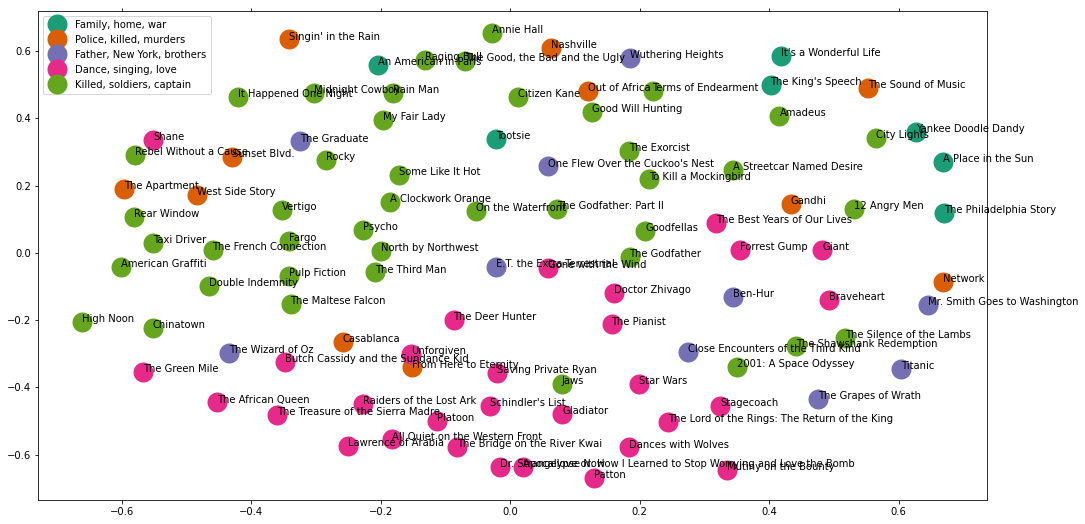

In [58]:

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# ms: marker size
for name, group in groups:
#     print(group)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=10)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# import plotly.plotly as py
# plot_url = py.plot_mpl(fig)